In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import laspy
import os
import geopandas as gpd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches


In [4]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

fig, axs = plt.subplots(3, 3, figsize=(20,20))

folders = os.listdir(parcelsFolder)

for i in range(len(folders)):
    subfolder = parcelsFolder + "/" + folders[i] + "/"
    fullDF = []
    for construction in [x for x in os.listdir(subfolder) if os.path.isdir(subfolder + x)]:
        lazFile = subfolder + construction + "/Map files/" + construction + ".laz"
      
        lasDF = laspy.read(lazFile)
        x, y, z = lasDF.xyz[:,0], lasDF.xyz[:,1], lasDF.xyz[:,2]

        fullDF.append((x, y, z))

    x, y, z = np.hstack([arr[0] for arr in fullDF]), np.hstack([arr[1] for arr in fullDF]), np.hstack([arr[2] for arr in fullDF])

    ax = axs[i // 3, i % 3]
    scatter = ax.scatter(x, y, c=z, s=1, cmap='viridis')
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')

    norm = Normalize(vmin=z.min(), vmax=z.max())
    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
    cbar.set_label('z (m)')

    for construction in [x for x in os.listdir(subfolder) if os.path.isdir(subfolder + x)]:
        gpkgFile = subfolder + construction + "/Map files/" + construction + ".gpkg"
        
        cadasterGDF = gpd.read_file(gpkgFile)
        cadasterGDF.plot(ax=ax, color='none', edgecolor='black')


       
plt.tight_layout()
plt.savefig(basePath + "/Results/" + neighborhood + "/LiDAR_Data.png", dpi=300)
print("Saved!")
#plt.show()

Saved!


**Prova: DBSCAN**

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

In [50]:
def plot_data(X, ax):
    ax.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, ax, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    ax.scatter(centroids[:, 0], centroids[:, 1],
               marker='o', s=35, linewidths=8,
               color=circle_color, zorder=10, alpha=0.9)
    ax.scatter(centroids[:, 0], centroids[:, 1],
               marker='x', s=2, linewidths=12,
               color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, ax, resolution=10, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy, zz = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution),
                         np.linspace(mins[2], maxs[2], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    ax.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
               linewidths=1, colors='k')
    # plot_data(X, ax)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_, ax)

    if show_xlabels:
        ax.set_xlabel("$x_1$")
    else:
        ax.tick_params(labelbottom=False)
    if show_ylabels:
        ax.set_ylabel("$x_2$", rotation=0)
    else:
        ax.tick_params(labelleft=False)

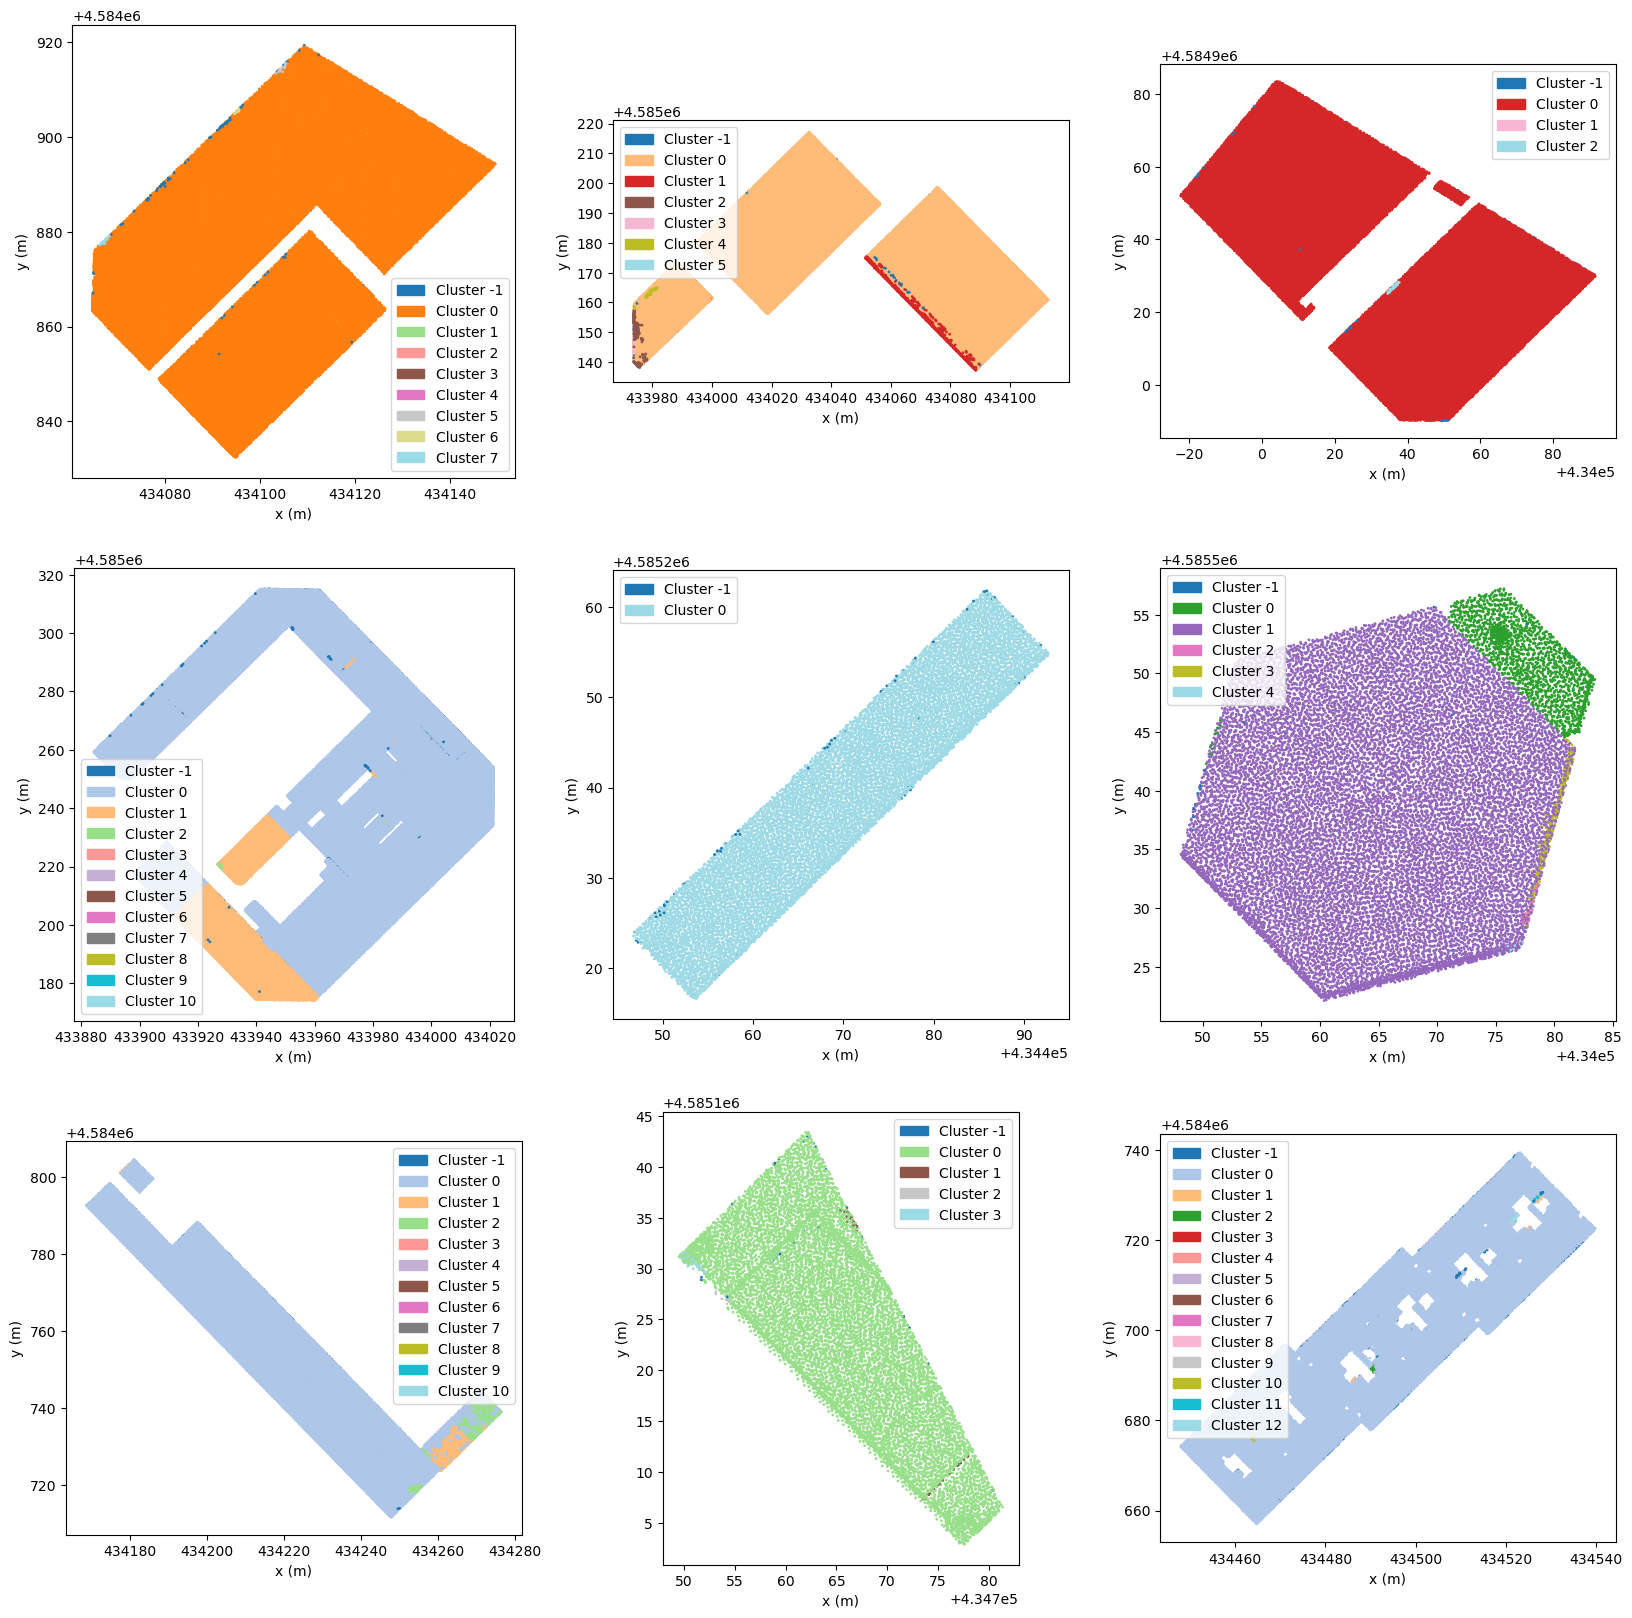

In [53]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

fig, axs = plt.subplots(3, 3, figsize=(20,20))

folders = os.listdir(parcelsFolder)

dbscan = DBSCAN(eps=1.5, min_samples=8)
for i in range(len(folders)):
    subfolder = parcelsFolder + "/" + folders[i] + "/"
    fullDF = []
    ax = axs[i // 3, i % 3]

    for construction in [x for x in os.listdir(subfolder) if os.path.isdir(subfolder + x)]:
        lazFile = subfolder + construction + "/Map files/" + construction + ".laz"
      
        lasDF = laspy.read(lazFile)
        
        
        x, y, z = lasDF.xyz[:,0], lasDF.xyz[:,1], lasDF.xyz[:,2]
        X_df = pd.DataFrame({"x": x, "y": y, "z": z})
        dbscan.fit(X_df)
        X_df['labels'] = dbscan.labels_

        fullDF.append((x, y, z, dbscan.labels_))
        
        knn = KNeighborsClassifier(n_neighbors=50)

        knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])
        # plot_decision_boundaries(knn, dbscan.components_, ax=ax, show_centroids=False)

    x = np.hstack([arr[0] for arr in fullDF])
    y = np.hstack([arr[1] for arr in fullDF])
    z = np.hstack([arr[2] for arr in fullDF])
    labels = np.hstack([arr[3] for arr in fullDF])
    
    
    scatter = ax.scatter(x, y, c=labels, s=1, cmap='tab20')
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')



     # Manually create legend
    unique_labels = np.unique(labels)
    legend_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(label)), label=f'Cluster {label}') 
                      for label in unique_labels]
    ax.legend(handles=legend_patches)

    # for construction in [x for x in os.listdir(subfolder) if os.path.isdir(subfolder + x)]:
    #     gpkgFile = subfolder + construction + "/Map files/" + construction + ".gpkg"
        
    #     cadasterGDF = gpd.read_file(gpkgFile)
    #     cadasterGDF.plot(ax=ax, color='none', edgecolor='black')



In [21]:
dbscan.components_[:, 0:2]

array([[ 434148.316, 4584893.218],
       [ 434148.112, 4584892.769],
       [ 434148.232, 4584893.066],
       ...,
       [ 434077.874, 4584852.333],
       [ 434077.414, 4584852.122],
       [ 434076.704, 4584851.519]])

In [23]:
plot_decision_boundaries(knn, X_df[['x', 'y', 'z']], show_centroids=False)

[4584677.074 4584677.074 4584677.074 ... 4584682.752 4584682.752
 4584682.752]


/tmp/ipykernel_45322/3772750678.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
/tmp/ipykernel_45322/3772750678.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.linspace(mins[1], maxs[1], resolution))


ValueError: X has 2 features, but KNeighborsClassifier is expecting 3 features as input.

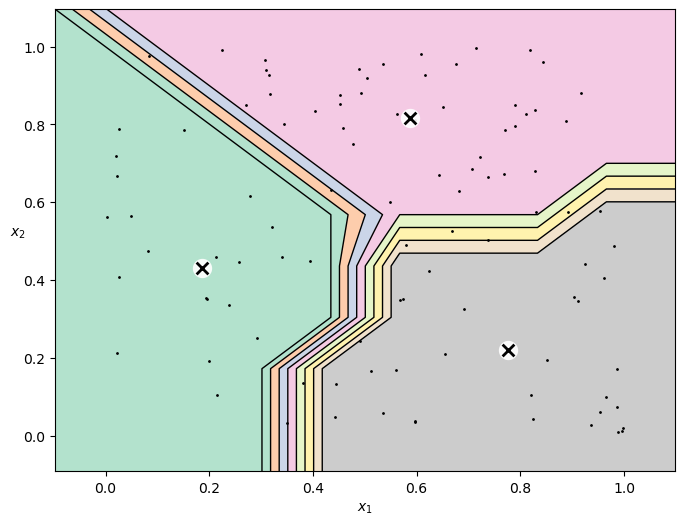

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Generate some data
X = np.random.rand(100, 2)

# Fit a clusterer
clusterer = KMeans(n_clusters=3, random_state=42)
clusterer.fit(X)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot using the modified functions
plot_decision_boundaries(clusterer, X, ax=ax, show_centroids=True)

plt.show()
